# HCLIM Validation 

[Paleoclimate reconstructions](https://doi.org/10.1029/2022RG000782) need to be thoroughly validated on independent data before they can be trusted. This notebook uses the [HCLIM dataset](https://doi.pangaea.de/10.1594/PANGAEA.940724),  to validate proxy-based paleoclimate reconstructions prior to the start of the instrumental era in 1850. The HCLIM dataset, compiled by Lundstad et al., is a comprehensive global monthly instrumental climate database containing over 12,000 pre-1890 meteorological records (including air temperature, pressure, precipitation sum, and precipitation days) from 118 countries, which is an extensive collection of preindustrial climate data that can be used for historical climate reconstructions and analyses. Specifically, we look at surface air temperature in HCLIM vs the [Last Millennium Reanalysis](https://doi.org/10.5194/cp-15-1251-2019). It's important to note, however, that complete data independence cannot be guaranteed since the sources of some of HCLIM's data is unclear/unknown and may have been used in datasets that calibrated post-1850 proxy system models in LMR.

## Loading HCLIM data


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyleoclim as pyleo
import os
import xarray as xr
import seaborn as sns

Load .tab files and combine all surface air temperature (TA) data into one pandas dataframe
# Data Structure and Processing

First, let's look at the raw data structure and an example with one of the files we want to use, specifically Ta (surface air temperature):\

as you can see, the data is organized in columns: station ID, Station Name, Latitude, Longitude, Elevation, URL source,	File name,	Date/Time,	TTT monthly m [°C],	Description source.\
Without including the actual temperature values, we can structure the data into a dictionary to understand the spatial and temporal spread of stations. 

In [38]:
# Show directory structure and file contents (example)
!echo "=== Directory structure ===" && ls -R datasets/ && \
echo "=== Example of file content (first 5 lines of Ta6.tab) ===" && \
sed -n '25,30p' datasets/Lundstad-etal_2022_Ta6.tab

=== Directory structure ===
Lundstad-etal_2022_NR1.tab            Lundstad-etal_2022_RR7.tab
Lundstad-etal_2022_NR2.tab            Lundstad-etal_2022_RR8.tab
Lundstad-etal_2022_NR3.tab            Lundstad-etal_2022_Ta1.tab
Lundstad-etal_2022_NR4.tab            Lundstad-etal_2022_Ta2.tab
Lundstad-etal_2022_NR_files.tab       Lundstad-etal_2022_Ta3.tab
Lundstad-etal_2022_Precip_files.tab   Lundstad-etal_2022_Ta4.tab
Lundstad-etal_2022_RR1.tab            Lundstad-etal_2022_Ta5.tab
Lundstad-etal_2022_RR2.tab            Lundstad-etal_2022_Ta6.tab
Lundstad-etal_2022_RR3.tab            Lundstad-etal_2022_Ta7.tab
Lundstad-etal_2022_RR4.tab            Lundstad-etal_2022_Tair_files.tab
Lundstad-etal_2022_RR5.tab            Lundstad-etal_2022_pressure.tab
Lundstad-etal_2022_RR6.tab            Lundstad-etal_2022_pressure_files.tab
=== Example of file content (first 5 lines of Ta6.tab) ===
GHCN_USW00014758	NEW_HAVEN_TWEED_AP	41.2639	-72.8872	1	ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v4	GHCN_v4_qcf_GH

We still want the temperature data to be easily readable. Read all csv files and combine them into one dataframe for easier access and readibility. Then identify all unique station IDs to see spread of locations. 

In [2]:
files = os.listdir('./datasets/')
data = []
for file in files:
    if ('_Ta' in file) and ('Tair' not in file):
        df = pd.read_csv(f'./datasets/{file}',sep='\t', skiprows=23)
        data.append(df)

df_ta = pd.concat(data)

# identify all unique station IDs
stations_id = df_ta['ID'].unique()

create dictionary for all stations wih lat/lon, start/end date, and length of timeseries. Then sort to get a separate dictionary with all stations with data prior to 1850. This will be beneficial to validate reconstructions without using data from the time frames used for the reconstruction. 


In [4]:

ta_dict = {}
for idx in stations_id:
    station_data = df_ta[df_ta['ID'] == idx]
    station_name = station_data['Station'].unique()[0]
    mini = station_data['Date/Time'].min()
    maxi = station_data['Date/Time'].max()
    lat = station_data['Latitude'].unique()[0]
    lon = station_data['Longitude'].unique()[0]
    length = len(station_data['TTT monthly m [°C]'].values)
    ta_dict[idx] = {'Station': station_name,
                'Date min': mini,
                'Date max': maxi,
                'Length': length,
                'Latitude': lat,
                'Longitude': lon}


In [5]:
# sort to obtain all stations that have records before 1850
old_ta = []
for idx in stations_id:
    val = int(ta_dict[idx]['Date min'][:-3])
    if 1850 >= val:
        old_ta.append(id)

old_ta_dict = {}
for idx in old_ta:
    old_ta_dict[idx] = ta_dict[idx]

In [6]:
# personal organization
sorted_date_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Date min']))

sorted_len_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Length'],
                         reverse = True))

### Visualizing spatial distribution of data

Using seaborn to visualize spread of data. This includes start year, end year, and length of each station data. Python datetime does not work on dates before 1659, so we need to make modifications with other functions to extract the dates in a readable way for our purposes. In this particular case, we only need the year, hence we can use the `date_change` function.

In [10]:
def date_change(date_str):
    year_str, month_str = date_str.split('-')
    
    year = int(year_str)
    
    return year

In [16]:
def create_station_viz(data_dict):
   
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index',
                               columns=['station', 'Date min', 'Date max', 
                                      'Length', 'latitude', 'longitude'])
    
    # Convert date strings to years
    df['start_year'] = df['Date min'].apply(date_change)
    df['end_year'] = df['Date max'].apply(date_change)
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Distribution of start years
    sns.histplot(data=df, x='start_year', ax=ax1, bins=20, color= 'royalblue')
    ax1.set_title('Distribution of Start Years')
    ax1.set_xlabel('Start Year')
    ax1.set_ylabel('Count')
    
    # Plot 2: Distribution of end years
    sns.histplot(data=df, x='end_year', ax=ax2, bins=20, color='seagreen')
    ax2.set_title('Distribution of End Years')
    ax2.set_xlabel('End Year')
    ax2.set_ylabel('Count')
    
    # Plot 3: Distribution of record lengths
    sns.histplot(data=df, x='Length', ax=ax3, bins=20, color='magenta')
    ax3.set_title('Distribution of Record Lengths')
    ax3.set_xlabel('Length (months)')
    ax3.set_ylabel('Count')
    
    plt.tight_layout()
    return fig

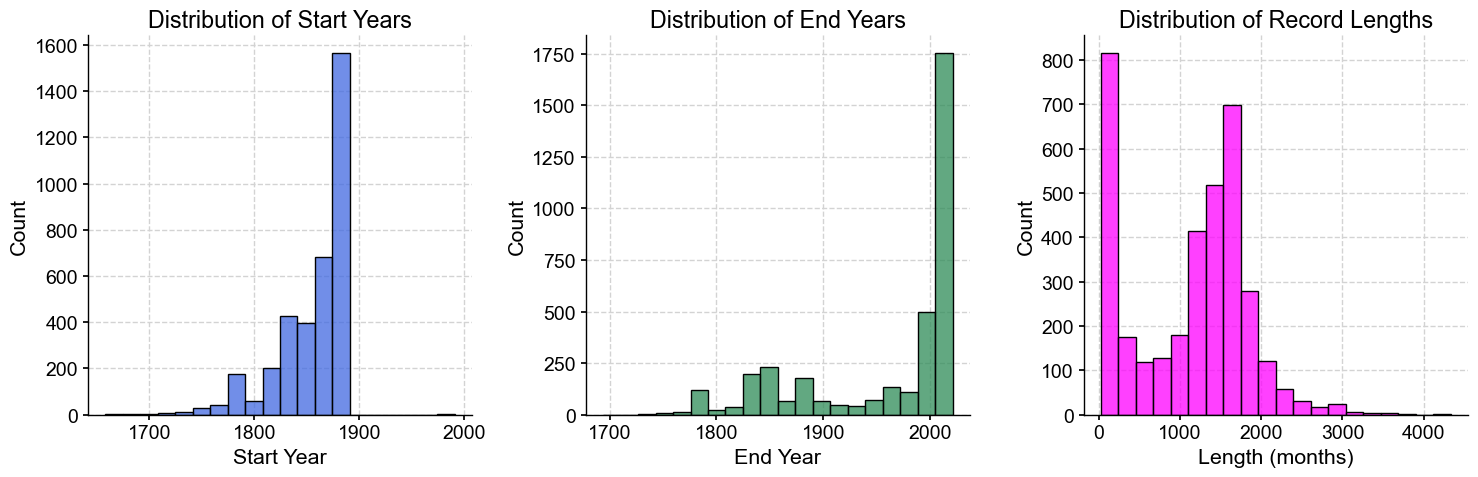

In [17]:
figg = create_station_viz(ta_dict)

Now we want to see the distribution of the stations data spatially with respect to the start year. `plot_stations` will show us the visualization on a Robinson projection. 

In [28]:

# function to plot all stations on Robinson Projection with respect to data start year
def plot_stations(dictionary):

    df = pd.DataFrame.from_dict(dictionary, orient='index')
    
    df['date_numeric'] = df['Date min'].apply(date_change)
    
    # Create the map
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()

    # Create colorbar (discrete)
    vmin = df['date_numeric'].min()
    vmax = df['date_numeric'].max()
    levels = np.linspace(vmin, vmax, 20)
    
    norm = BoundaryNorm(levels, plt.get_cmap('magma').N)
    
    scatter = ax.scatter(df['Longitude'], 
                        df['Latitude'],
                        c=df['date_numeric'],
                        transform=ccrs.PlateCarree(),
                        cmap='magma',
                        s=20,
                        alpha=0.6,
                        zorder=5,
                        norm=norm)
    
    # Add colorbar with discrete levels and formatted year labels
    cbar = plt.colorbar(scatter, ticks=levels[::2])
    cbar.set_label('Start Year')
    cbar.ax.set_yticklabels([f'{int(year)}' for year in levels[::2]])

    
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5)
    
    plt.title('HCLIM Station Locations by Oldest Data \n(surface air temp)')
    
    return fig, ax

(<Figure size 1200x800 with 2 Axes>,
 <GeoAxes: title={'center': 'HCLIM Station Locations by Oldest Data \n(surface air temp)'}>)

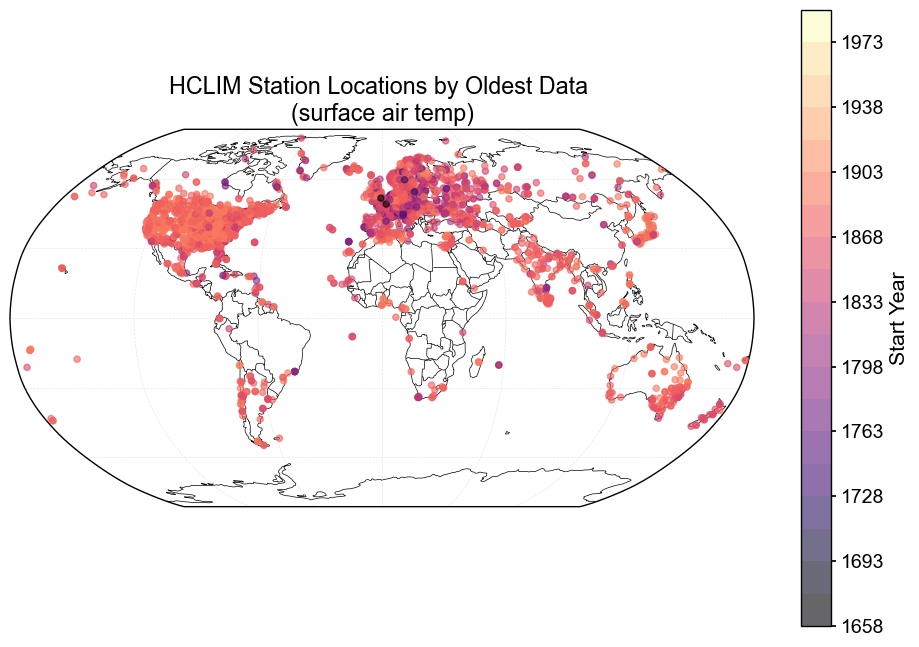

In [29]:
plot_stations(ta_dict)

## Loading Specific Station data (HCLIM)

### Paris
While there was a selection of close to 3000 stations in which temperaure data was recorded, the Paris (Lat: 48.87, Lon: 2.35, Elevation: NaN) station data as compiled in [EKF400](https://doi.org/10.1002/gdj3.121) is the longest and most complete record in HCLIM. Starting with this record would give a good baseline to show validation with as few missing pieces as possible. 

We use `date_to_decimal_year` as an alternative to converting the strings given in the HCLIM data to datetime object. Because the data spans from 1650, Python's built in datetime function cannot convert the older dates (limited to dates after 1659). Hence in order to preserve the monthly format, we convert the date strings into decimals to still get an accurate timeseries to use for our validation. 

In [47]:
# converting date from string to decimal format 

from datetime import datetime

def date_to_decimal_year(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, '%Y-%m')
    
    # Get the year and month
    year = date.year
    month = date.month
    
    # Convert to decimal year (year + fraction of the year)
    decimal_year = year + (month - 1) / 12
    
    return decimal_year

`station_extraction` is function for loading singular station data from our larger dataframe with added visuals. df is the original dataframe, ID is station ID, slice_start/end are optional parameters to zoom in on smaller time periods of our data. This function can be used to retreive data from any of the thousands of stations within the HCLIM dataset. The output is a [Pyleoclim_GeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#geoseries-pyleoclim-geoseries), both the full length, and our requested slice, which returns latitude/longitude/elevation and makes it more straighforward to map. 

In [ ]:

def station_extraction(df, ID, slice_start, slice_end):

    #load in dataframe by ID and convert years to decimal form
    df_loc = df[df['ID']==ID]
    df_loc['Date/Time'] = df_loc['Date/Time'].apply(date_to_decimal_year)

    # get latitude and longitude
    lats = round(df_loc['Latitude'].iloc[0])
    longs = round(df_loc['Longitude'].iloc[0])

    # start and end year
    if slice_start == None:
        slice_start = df_loc['Date/Time'].min()
    if slice_end == None:
            slice_end = df_loc['Date/Time'].max()

    #annualizing with same reference date range as LMR
    years = np.floor(df_loc['Date/Time'])

    loc_annual = df_loc.groupby(years)['TTT monthly m [°C]'].mean()

    ref_period_mean = loc_annual[
        (loc_annual.index >= 1951) & 
        (loc_annual.index <= 1980)
    ].mean()

    # Calculate anomalies
    loc_annual_anomalies = loc_annual - ref_period_mean
    timey = loc_annual_anomalies.index.values  
    valuey = loc_annual_anomalies.values

    loc_annual_ps = pyleo.Series(
        time=timey,
        value=valuey,
        time_name='Year',
        time_unit= 'year',
        value_name='Temperature anomaly',
        value_unit='°C'
    )

    loc_annual_slice = loc_annual_ps.sel(time=slice(slice_start, slice_end)) # not pyloclim (annual mean)

    loc_annual_ps.plot(title=f'Annualized surface air temperature at {ID}')
    loc_annual_slice.plot(title=f'Slice of above plot {ID}')

    return lats, longs, loc_annual_ps, loc_annual_slice


In [ ]:
def station_extraction(df, ID, slice_start=None, slice_end=None):
    """
    Parameters
    -------------
    df: Pandas DataFrame with all HCLIM data
    ID: specific station ID
    slice start: initial year or None
    slice_end: final year or None

    Returns
    -------------
    loc_annual_ps: Pyleoclim GeoSeries object at specified station/location
    loc_annual_slice: Pyleoclim GeoSeries object with specific time slice
    """

    #load in dataframe by ID and convert years to decimal form
    df_loc = df[df['ID']==ID]
    df_loc['Date/Time'] = df_loc['Date/Time'].apply(date_to_decimal_year)

    # get latitude, longitude, and station name
    lats = round(df_loc['Latitude'].iloc[0])
    longs = round(df_loc['Longitude'].iloc[0])
    station_name = df_loc['Station'].iloc[0]
    elevation = df_loc['Elevation [m a.s.l.]'].iloc[0]

    # start and end year
    if slice_start == None:
        slice_start = df_loc['Date/Time'].min()
    if slice_end == None:
        slice_end = df_loc['Date/Time'].max()

    #annualizing with same reference date range as LMR
    years = np.floor(df_loc['Date/Time'])
    loc_annual = df_loc.groupby(years)['TTT monthly m [°C]'].mean()

    ref_period_mean = loc_annual[
        (loc_annual.index >= 1951) & 
        (loc_annual.index <= 1980)
    ].mean()

    # Calculate anomalies
    loc_annual_anomalies = loc_annual - ref_period_mean
    timey = loc_annual_anomalies.index.values  
    valuey = loc_annual_anomalies.values

    # Create GeoSeries with station name as label
    loc_annual_ps = pyleo.GeoSeries(
        time=timey,
        value=valuey,
        lat=lats,
        lon=longs,
        elevation=elevation,
        time_name='Year',
        time_unit='year',
        value_name='Temperature anomaly',
        value_unit='°C',
        archiveType='Instrumental',
        observationType='Temperature',
        label=station_name
    )

    loc_annual_slice = loc_annual_ps.sel(time=slice(slice_start, slice_end))

    return loc_annual_ps, loc_annual_slice

In [53]:
paris_ps, paris_slice_ps = station_extraction(df_ta,'EKF400v2t_002',1650,1850 )

Time axis values sorted in ascending order


To visualize the GeoSeries, we can use a PyleoClim [dashboard](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.geoseries.GeoSeries.dashboard). This will show us a plot of the temperature anomaly, histogram of the values, a map of the location, and PSD. We can make this usable for any station and any GeoSeries with the function `plot_dashboard`.
The temperature anomaly plot shows the time series evolution of the temperature anomaly. The histogram shows the distribution of temperature variations and can identify if the variations are normally distributed. The PSD (power spectral density) shows us the dominant periodocities in our data.

In [ ]:
def plot_dashboard(geoseries):
 '''
 Parameters:
 ---------
 geoseries: Pyleoclim GeoSeries object

 Returns:
 ----------
 fig,ax: dashboard figure

 '''  
    # Create dashboard with corrected spectral settings
    fig, ax = geoseries.dashboard(
        figsize=[15,10],
        plt_kwargs={
            'title': f"Temperature record analysis for {geoseries.label}",
            'color': 'darkred',
            'linewidth': 1.0
        },
        spectral_kwargs={
            'method': 'lomb_scargle',
            'settings': {
                'freq_method': 'log'  
            }
        },
        map_kwargs={
            'projection': 'auto',
            'land': True,
            'borders': True,
            'lakes': True,
            'ocean': {'color': 'lightblue'},
            'gridlines': True
        }
    )
    
    return fig, ax



Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:03<00:00, 61.26it/s]


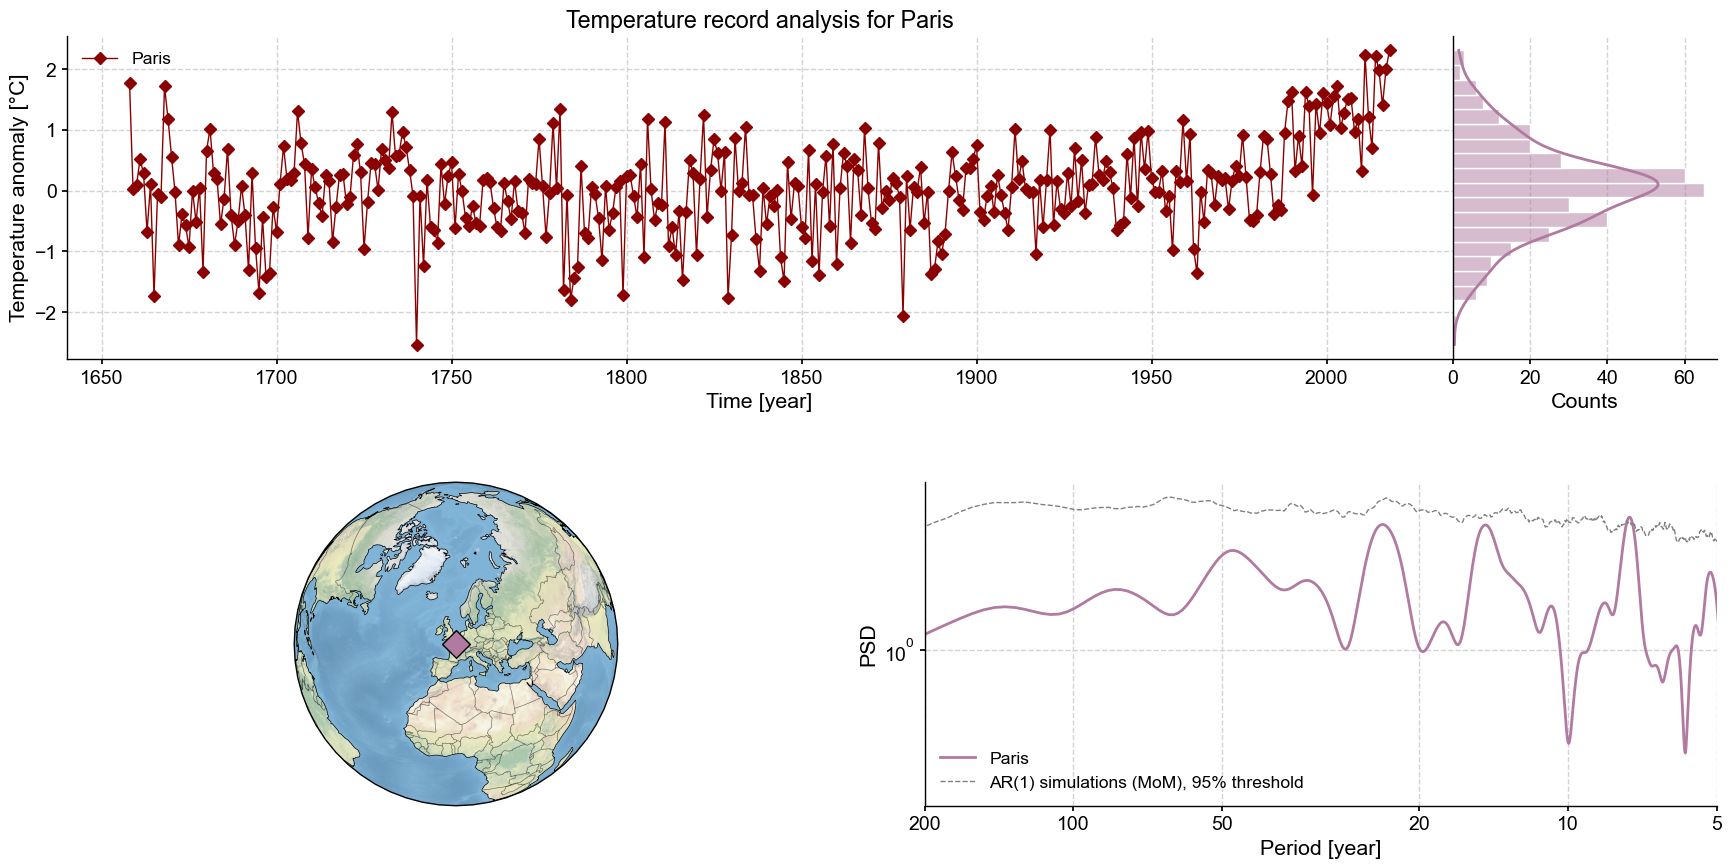

In [63]:
fig, ax = plot_dashboard(paris_ps)

### New Haven 

Within HCLIM's datasets, the most complete documenary records tend to be from Europe, but in order to see temperature records on another continent, we will observe data from New Haven, CT, USA from [BerkeleyEarth](https://berkeleyearth.org/data/). We will use the same functions as for Paris to visualize the data in a dashboard.

In [65]:
nh_ps, nh_slice_ps = station_extraction(df_ta,'BE-68050', 1750,1850 )

NaNs have been detected and dropped.
Time axis values sorted in ascending order


Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:01<00:00, 157.28it/s]


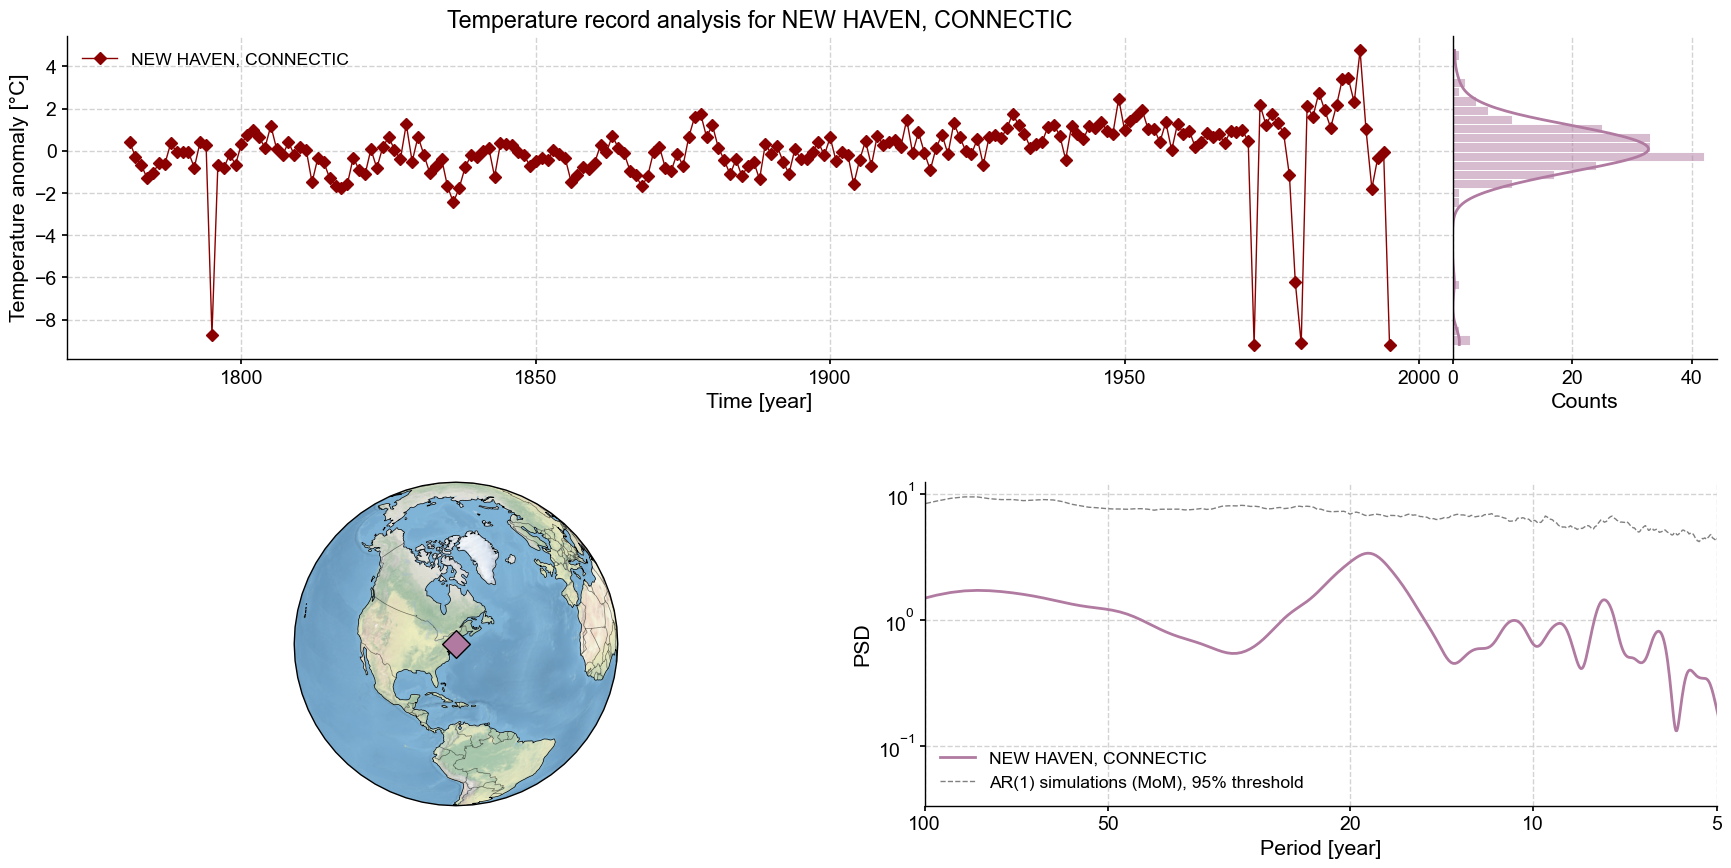

In [66]:
fig2, ax2 = plot_dashboard(nh_ps)

Compared to the Paris data, New Haven has much more obvious and frequent outliers in terms of temperature anomalies. The value distribution also skews right, making the data not as normally distributed as we would expect. The PSD shows more subdued variability and only one significantly large peak at the 20 year period, unlike Paris, which has many peaks throughout. 

## A Rudimentary Comparison
* add description *

### Loading LMRv2.1

* add description from Jordan's nb * 

In [72]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

<xarray.Dataset>
Dimensions:        (time: 2001, MCrun: 20, lat: 91, lon: 180)
Coordinates:
  * lat            (lat) float32 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time           (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun
Data variables: (12/14)
    air_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    air_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_mean    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_spread  (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_mean      (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_spread    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    ...             ...
    prate_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prate_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
Attributes:
    comment:      File contains ensemble spread values for each Monte-Carlo r...
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_z500

create a function `extract_LMR_gridpoint` that takes in LMRv2.1 xarray.Dataset object and our specified station GeoSeries and outputs a [Pyleclim_EnsembleSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#ensembleseries-pyleoclim-ensembleseries) object 

In [73]:
def extract_LMR_gridpoint(target_series, lmr_ds_gridded=lmr_ds_gridded, time_slice=None):
    """
    Extract LMR ensemble data at a gridpoint specified by a GeoSeries object
    
    Parameters
    ----------
    target_series : pyleo.GeoSeries
    time_slice : tuple or None
    lmr_ds_gridded : xarray.Dataset

    Returns
    -------
    pyleo.EnsembleSeries
    """
    # Extract coordinates from target series
    target_lat = target_series.lat
    target_lon = target_series.lon
    
    # Get data at specified gridpoint
    grid_point_loc = lmr_ds_gridded.air_mean.sel(
        lat=target_lat,
        lon=target_lon,
        method='nearest'
    )

    # Convert time values to numeric years
    time_values_numeric = np.array([t.year for t in grid_point_loc.time.values])
    
    # If time_slice is None, use full range
    if time_slice is None:
        mask = np.ones_like(time_values_numeric, dtype=bool)
    else:
        time_start, time_end = time_slice
        mask = (time_values_numeric >= time_start) & (time_values_numeric <= time_end)

    # Create series for each ensemble member
    traces = []
    for i in range(grid_point_loc.shape[1]):
        values = grid_point_loc[mask, i].values
        
        series = pyleo.Series(
            time=time_values_numeric[mask],
            value=values,
            time_name='Year',
            time_unit='CE',
            value_name='Air Temperature',
            value_unit='°C',
            label=f'Ensemble Member {i+1}',
            verbose=False
        )
        traces.append(series)

    # Create an EnsembleSeries object
    ensemble = pyleo.EnsembleSeries(traces)

    return ensemble

# Usage examples:
# Use full time range:
# lmr_ensemble = extract_LMR_gridpoint(paris_ps, None, lmr_ds_gridded)
# 
# Use specific time range:
# time_slice = (850, 2000)
# lmr_ensemble = extract_LMR_gridpoint(paris_ps, time_slice, lmr_ds_gridded)

### Loading Paris gridpoint (LMR)
taking the closest gridpoint to our Paris HCLIM station to do a gridpoint validation 

In [74]:
ensemble_paris = extract_LMR_gridpoint(paris_ps, lmr_ds_gridded=lmr_ds_gridded, time_slice=None)

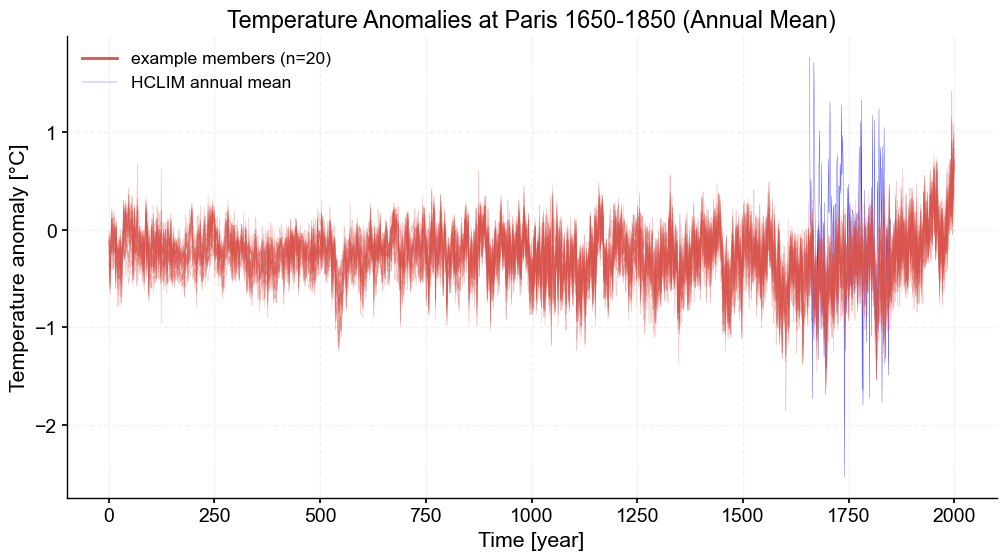

In [75]:
# Create visualization
fig, ax = ensemble_paris.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6),
    lgd_kwargs = {'labels': ['MC iterations']}
)

paris_slice_ps.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at Paris 1650-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

We notice here that the general trends of the LMR ensemble and our HCLIM plot are the same, but what varies significantly is the amplitude. This could be due to the fact that LMR uses spatial averaging, dampening it. On the other hand, HCLIM comes from one station directly and hence is less susceptible to any outside climate influences from further stations. 

### Loading New Haven gridpoint (LMR)

In [ ]:
ensemble_nh = extract_LMR_gridpoint(nh_slice_ps, lmr_ds_gridded=lmr_ds_gridded, time_slice=None)

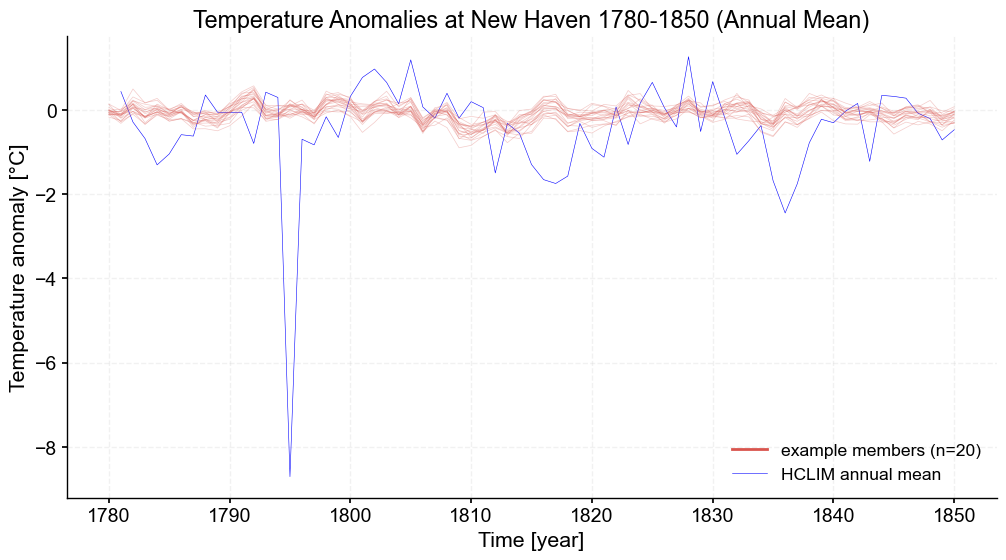

In [28]:
# Create visualization
fig, ax = ensemble_nh.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

nh_slice_ps.plot(ax=ax, linewidth=0.4, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at New Haven 1780-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

Despite having some trendlines show as similar between LMR ensembles and HCLIM data, the New Haven station appears to not have very consistent instrumental record. If it is accurate, then the reconstruction has been heavily dampened by the DA process. 

## Comparisons Accounting for Reconstruction Uncertainties

In [84]:
def combine_spread(spread):
    return np.sqrt(np.sum(spread**2, axis=-1))

def statistics(geoseries):
    lat = geoseries.lat
    lon = geoseries.lon

    point_data = lmr_ds_gridded.sel(lat=lat, lon=lon, method='nearest')

    # Calculate statistics (mean and spread)
    mean_temp = point_data.air_mean.mean(dim='MCrun')
    gaussian_spread = xr.apply_ufunc(
        combine_spread,
        point_data.air_spread,
        input_core_dims=[['MCrun']],
        output_core_dims=[[]],
        vectorize=True,
        dask='allowed'
    )

    # Create error bounds
    upper_bound = mean_temp + gaussian_spread
    lower_bound = mean_temp - gaussian_spread

    # Convert cftime objects to years
    years = np.array([t.year for t in point_data.time.values])

    return years, mean_temp, upper_bound, lower_bound

### Paris

In [85]:
paris_stats = statistics(paris_ps)

In [ ]:
def plot_mean_spread(stats, geoseries):
    """
    Parameters
    -----------
    stats: statistics function (returns years, mean temp, upper bound, lower bound)
    geoseries: Pyleoclim GeoSeries of station we are comparing 

    Returns
    ---------
    plot of HCLIM data vs LMR spread
    """
    latt = geoseries.lat
    long = geoseries.lon

    years, mean_temp, upper, lower = stats

    lmr_series = pyleo.Series(
        time=years,
        value=mean_temp,
        time_name='Year',
        time_unit='CE',
        value_name='Temperature',
        value_unit='°C'
        )

    corr = geoseries.correlation(
        target_series=lmr_series,
        statistic='pearsonr',
        method='phaseran',  # phase randomization method for significance
        number=1000,        # number of surrogate series
        alpha=0.05          # significance level
        )

    plt.figure(figsize=(12, 6))
    plt.plot(years, mean_temp, label='Mean Temperature')
    plt.plot(geoseries.time, geoseries.value, linewidth=0.8, color='red', label=f'HCLIM {geoseries.label}')
    plt.fill_between(years, lower, upper, alpha=0.2, label='Spread')
    
    p_text = 'p < 0.001' if corr.p < 0.001 else f'p = {corr.p:.2e}'
    stats_text = (f'r = {corr.r:.2f}\n')

    # Add correlation text 
    plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel('Year')
    plt.ylabel('Temperature')
    plt.title(f'Temperature at lat={latt}, lon={long}')
    plt.legend()
    plt.grid(True)

Time axis values sorted in ascending order


Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1232.49it/s]


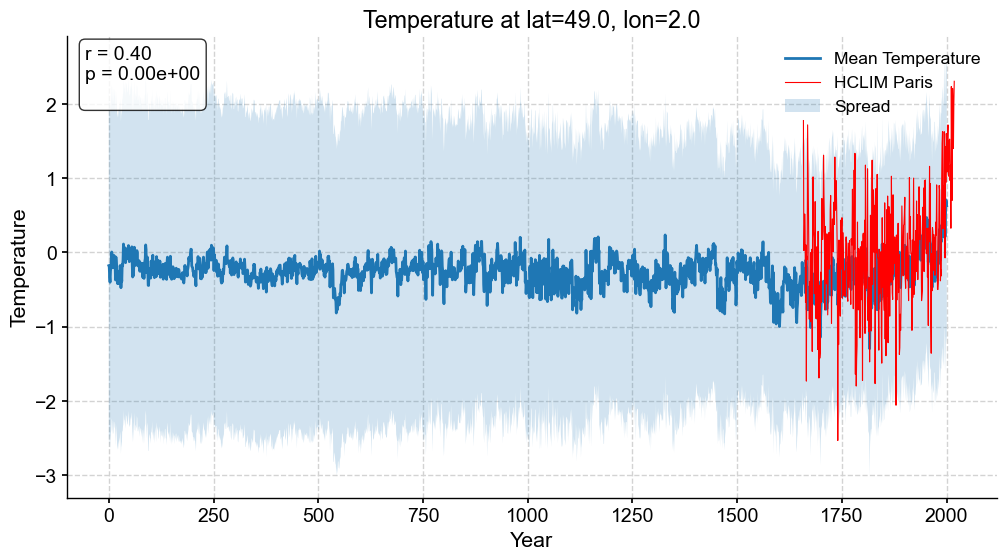

In [97]:
plot_mean_spread(paris_stats,paris_ps)

### New Haven

In [91]:
nh_stats = statistics(nh_ps)

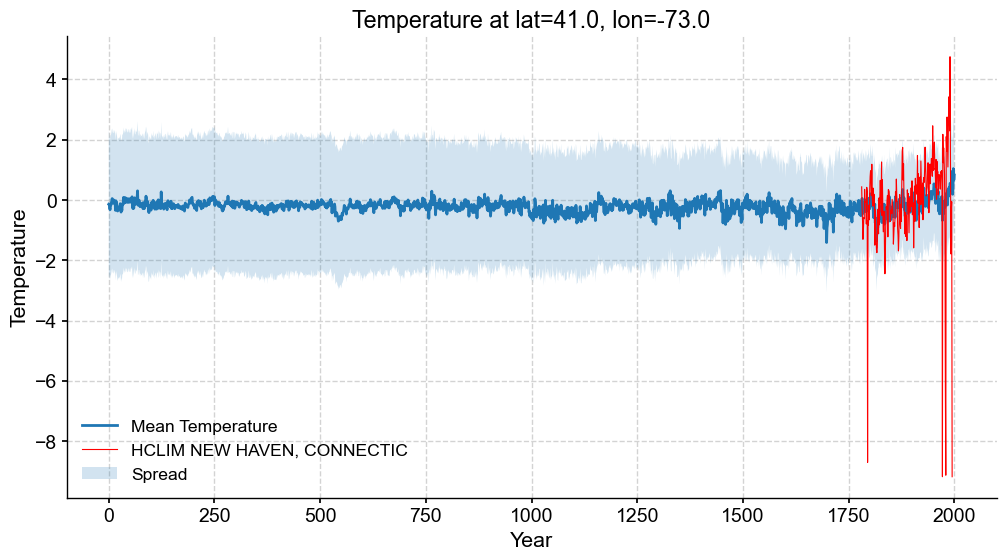

In [92]:
plot_mean_spread(nh_stats,nh_ps)

As mentioned briefly LMR and HCLIM have different methods for recording temperature at a grdipoint, namely, local variability vs grid-point average. We expect variance to be lower for LMR grid points than any station data because of the inherent spatial averaging that happens on the coarse grid used by LMR. 

In [95]:
# testing testing 123

years, mean_temp, upper, lower = statistics(paris_ps)

lmr_series = pyleo.Series(
        time=years,
        value=mean_temp,
        time_name='Year',
        time_unit='CE',
        value_name='Temperature',
        value_unit='°C'
    )

corr = paris_ps.correlation(
        target_series=lmr_series,
        statistic='pearsonr',
        method='phaseran',  # phase randomization method for significance
        number=1000,        # number of surrogate series
        alpha=0.05          # significance level
    )

print(corr)

Time axis values sorted in ascending order


Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1405.21it/s]

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     0.401416  < 1e-6     True

